In [55]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG

import numpy as np

import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback
from keras.utils import model_to_dot

from sklearn import decomposition
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

### PCA Data Transformation

In [56]:
def pca_data_transform(X):
    X_out = np.zeros_like(X)
    for i in range(X_out.shape[0]):
        X_sample = X[i]
        X_reshape = X_sample.reshape(-1,X_sample.shape[2])
        pca = decomposition.PCA(n_components=3)
        X_pca = pca.fit_transform(X_reshape)
        X_pca = X_pca.reshape(X_sample.shape)
        X_out[i] = X_pca
    
    return X_out

### Model Definition and Training

In [65]:
# def train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size):
#     # Create model
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=5, input_shape=(image_resize,image_resize,3)))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
#     model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
#     model.add(Dropout(dropout))

#     model.add(Conv2D(64, kernel_size=4))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
#     model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
#     model.add(Dropout(dropout))

#     model.add(Conv2D(128, kernel_size=3))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
#     model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
#     model.add(Dropout(dropout))

#     # model.add(Conv2D(256, kernel_size=3, activation='relu'))
#     # model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

#     model.add(Dropout(dropout))
#     model.add(Flatten())
    
#     model.add(Dense(fully_connected_nodes))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
    
#     model.add(Dropout(dropout))

#     model.add(Dense(Nber_of_breeds, activation='relu'))

#     # Compile model
#     model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"
#     print(model_name)
    
#     checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
#     early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#     adam = keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train model
#     history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)
    
#     return model, history

In [80]:
def train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size):
    # Create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(image_resize,image_resize,3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(64, kernel_size=4, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    # model.add(Conv2D(256, kernel_size=3, activation='relu'))
    # model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(fully_connected_nodes, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(Nber_of_breeds, activation='softmax'))

    # Compile model
    model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"
    print(model_name)
    
    checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)
    
    return model, history

### Model Evaluation

In [81]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels_name):
    predictions = model.predict(X_test)
    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    accuracy = accuracy_score(true_argmax, pred_argmax)
    conf_matrix = confusion_matrix(true_argmax, pred_argmax)
    
    df = pd.DataFrame(conf_matrix)
    df = df.T
    df.columns = labels_name
    df = df.T
    df.columns = labels_name
    
    y_true = np.array(true_argmax)
    y_scores = np.array(pred_argmax)
    
    precision = precision_score(y_true, y_scores, average='weighted')
    
    recall = recall_score(y_true, y_scores, average='weighted')
    
    return accuracy, recall, precision , df

### Hyperparameters

In [82]:
# Data params
image_resize = 60
Nber_of_breeds = 8
use_pca = False

# Model params
dropout = 0.5
fully_connected_nodes = 500
learning_rate=0.0005
# learning_rates= [0.0001, 0.0005, 0.001]

# Training params
epochs = 50
batch_size = 20

### Load data

In [83]:
# Load data
X = pickle.load(open("pickles/X_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
y = pickle.load(open("pickles/y_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
labels_name = pickle.load(open("pickles/labels_name_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))

num_validation = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_validation)

# PCA
if use_pca:
    X_train = pca_data_transform(X_train)
    X_test = pca_data_transform(X_test)

### Train Model

model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06240, saving model to models/model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06240 to 1.94892, saving model to models/model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss did not improve from 1.94892



Epoch 00004: val_loss improved from 1.94892 to 1.73947, saving model to models/model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.73947



Epoch 00006: val_loss did not improve from 1.73947



Epoch 00007: val_loss improved from 1.73947 to 1.71946, saving model to models/model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.71946



Epoch 00009: val_loss improved from 1.71946 to 1.67143, saving model to models/model_60x60_8breeds_0.5dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.67143



Epoch 00011: val_loss did not improve from 1.67143



Epoch 00012: val_loss did not improve from 1.67143



Epoch 00013: val_loss did not improve from 1.67143



Epoch 00014: val_loss did not improve from 1.67143
Epoch 00014: early stopping



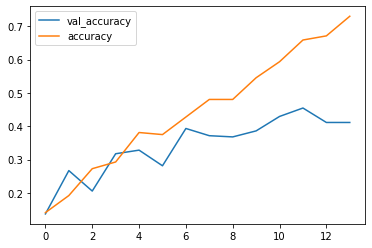

In [84]:
model, history = train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.plot(history.history["accuracy"], label = "accuracy")
plt.legend();

In [77]:
# for learning_rate in learning_rates:
#     train_model(image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

### Evaluate Model

In [85]:
accuracy, recall, precision, conf_matrix = evaluate_model(model, X_train, y_train, X_test, y_test, labels_name)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
conf_matrix

Accuracy: 0.41155234657039713
Recall: 0.41155234657039713
Precision: 0.423256917570997


,afghan_hound,bernese_mountain_dog,entlebucher,great_pyrenees,maltese_dog,pomeranian,scottish_deerhound,shih-tzu
afghan_hound,12,1,2,4,1,9,1,1
bernese_mountain_dog,1,22,6,0,0,1,0,0
entlebucher,2,11,21,0,0,1,2,2
great_pyrenees,5,2,2,8,4,5,3,3
maltese_dog,1,1,2,3,15,16,1,2
pomeranian,1,1,1,4,5,19,0,0
scottish_deerhound,6,2,2,4,2,8,12,1
shih-tzu,0,5,4,5,8,6,3,5


### K-Fold Cross Validation

In [54]:
n_splits = 5


accuracies = []
recalls = []
precisions = []
conf_matrices = []

# K-Fold cross validation
i = 0
kf = KFold(n_splits=n_splits)
for train, test in kf.split(X, y):
    i += 1
    # Train model
    print("Training split:", i, "of", n_splits)
    model, history = train_model(X[train], y[train], X[test], y[test], image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)
    
    # Evaluate model
    print("Evaluating split:", i, "of", n_splits)
    accuracy, recall, precision, conf_matrix = evaluate_model(model, X[train], y[train], X[test], y[test], labels_name)
    
    # Record metrics
    print("Recording metrics:", i, "of", n_splits)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    conf_matrices.append(conf_matrix)
    
    print("\n")
    
# Print average metrics
print("Average Mean:", np.asarray(accuracies).mean())
print("Average Recall:", np.asarray(recalls).mean())
print("Average Precision:", np.asarray(precisions).mean())

Training split: 1 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05521, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05521 to 1.94423, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.94423 to 1.80165, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.80165



Epoch 00005: val_loss improved from 1.80165 to 1.78992, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.78992



Epoch 00007: val_loss improved from 1.78992 to 1.78533, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss improved from 1.78533 to 1.77383, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss did not improve from 1.77383



Epoch 00010: val_loss improved from 1.77383 to 1.76658, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss did not improve from 1.76658



Epoch 00012: val_loss did not improve from 1.76658



Epoch 00013: val_loss did not improve from 1.76658



Epoch 00014: val_loss did not improve from 1.76658



Epoch 00015: val_loss did not improve from 1.76658
Epoch 00015: early stopping

Evaluating split: 1 of 5
Recording metrics: 1 of 5


Training split: 2 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06630, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06630 to 1.85882, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.85882 to 1.80713, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.80713 to 1.74157, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.74157 to 1.68323, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.68323 to 1.59082, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.59082 to 1.55089, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss improved from 1.55089 to 1.51840, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss improved from 1.51840 to 1.51351, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.51351



Epoch 00011: val_loss improved from 1.51351 to 1.47884, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.47884



Epoch 00013: val_loss did not improve from 1.47884



Epoch 00014: val_loss did not improve from 1.47884



Epoch 00015: val_loss improved from 1.47884 to 1.47601, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00016: val_loss did not improve from 1.47601



Epoch 00017: val_loss did not improve from 1.47601



Epoch 00018: val_loss did not improve from 1.47601



Epoch 00019: val_loss did not improve from 1.47601



Epoch 00020: val_loss did not improve from 1.47601
Epoch 00020: early stopping

Evaluating split: 2 of 5
Recording metrics: 2 of 5


Training split: 3 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.07842, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.07842 to 1.94000, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.94000 to 1.87163, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.87163 to 1.82452, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.82452 to 1.70263, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.70263



Epoch 00007: val_loss did not improve from 1.70263



Epoch 00008: val_loss did not improve from 1.70263



Epoch 00009: val_loss improved from 1.70263 to 1.63880, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss improved from 1.63880 to 1.62767, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss did not improve from 1.62767



Epoch 00012: val_loss did not improve from 1.62767



Epoch 00013: val_loss did not improve from 1.62767



Epoch 00014: val_loss did not improve from 1.62767



Epoch 00015: val_loss did not improve from 1.62767
Epoch 00015: early stopping

Evaluating split: 3 of 5
Recording metrics: 3 of 5


Training split: 4 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06684, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06684 to 1.95074, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.95074 to 1.82183, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.82183 to 1.79345, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.79345 to 1.74340, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.74340



Epoch 00007: val_loss improved from 1.74340 to 1.64286, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.64286



Epoch 00009: val_loss improved from 1.64286 to 1.62606, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.62606



Epoch 00011: val_loss did not improve from 1.62606



Epoch 00012: val_loss did not improve from 1.62606



Epoch 00013: val_loss improved from 1.62606 to 1.61761, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00014: val_loss did not improve from 1.61761



Epoch 00015: val_loss did not improve from 1.61761



Epoch 00016: val_loss did not improve from 1.61761



Epoch 00017: val_loss did not improve from 1.61761



Epoch 00018: val_loss did not improve from 1.61761
Epoch 00018: early stopping

Evaluating split: 4 of 5
Recording metrics: 4 of 5


Training split: 5 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.04259, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.04259 to 1.87585, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.87585 to 1.73962, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.73962



Epoch 00005: val_loss improved from 1.73962 to 1.63994, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.63994 to 1.60277, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss did not improve from 1.60277



Epoch 00008: val_loss did not improve from 1.60277



Epoch 00009: val_loss did not improve from 1.60277



Epoch 00010: val_loss improved from 1.60277 to 1.57071, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss improved from 1.57071 to 1.54974, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss improved from 1.54974 to 1.54596, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00013: val_loss did not improve from 1.54596



Epoch 00014: val_loss did not improve from 1.54596



Epoch 00015: val_loss did not improve from 1.54596



Epoch 00016: val_loss did not improve from 1.54596



Epoch 00017: val_loss did not improve from 1.54596
Epoch 00017: early stopping

Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.42078730904817857
Average Recall: 0.42078730904817857
Average Precision: 0.44645292643147194


### Image Size vs Accuracy - 8 Classes

Loading model: model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


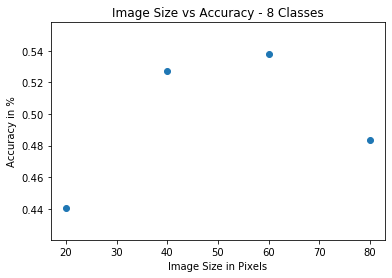

In [53]:
# Data params
image_resizes = [20, 40, 60, 80]
Nber_of_breeds = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0005

# Training params
batch_size = 20

models = []
for size in image_resizes:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for size, model_name in zip(image_resizes, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(image_resizes, accuracies);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Accuracy in %");
plt.title(f"Image Size vs Accuracy - {Nber_of_breeds} Classes");

### Number of Breeds vs Accuracy - 60x60 Images

Loading model: model_60x60_4breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_16breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_32breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_64breeds_0.3dropout_0.0001lr_500fc_20batch


/home/nschenon/.local/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


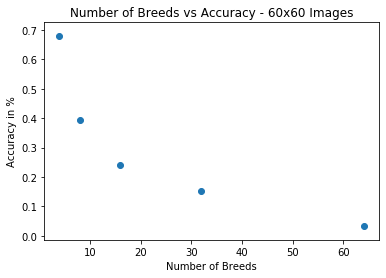

In [11]:
# Data params
size = 60
num_breeds = [4, 8, 16, 32, 64]

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0001

# Training params
batch_size = 20

models = []
for breed in num_breeds:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for breed, model_name in zip(num_breeds, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(num_breeds, accuracies);
plt.xlabel("Number of Breeds");
plt.ylabel("Accuracy in %");
plt.title(f"Number of Breeds vs Accuracy - {size}x{size} Images");

### Learning Rate vs Accuracy - 60x60 Images

Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


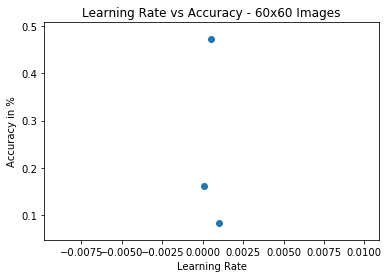

In [12]:
# Data params
size = 60
breed = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rates= [0.0001, 0.0005, 0.001]

# Training params
batch_size = 20

models = []
for learning_rate in learning_rates:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for breed, model_name in zip(num_breeds, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(learning_rates, accuracies);
plt.xlabel("Learning Rate");
plt.ylabel("Accuracy in %");
plt.title(f"Learning Rate vs Accuracy - {size}x{size} Images");